ResNet Time:

Task 1: Implement ResNet-50 for CIFAR-10 dataset.

Follow the original paper for the architecture (Modern CNN - Part 2 -- Page 9)



Change runtime to GPU. 

In [1]:
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 15101 MiB



Load libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

Building residual block of the ResNet

In [3]:
class Residual(tf.keras.Model): 
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

Some architecture choices:
Number of filters was 64, changed to 32,
Use dropout (dropout rate = 0.5)

In [4]:
b1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

"ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved."

In [5]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

Add modules to ResNet. 2 Residual blocks are used for each module when making 18-layer cake. 
b2 = ResnetBlock(32, 2, first_block=True)
b3 = ResnetBlock(64, 2)
b4 = ResnetBlock(128, 2)
b5 = ResnetBlock(256, 2)

We're going for a 50-layer cake. Delicious. 

In [6]:
b2 = ResnetBlock(32, 3, first_block=True)
b3 = ResnetBlock(64, 4)
b4 = ResnetBlock(128, 6)
b5 = ResnetBlock(256, 3)

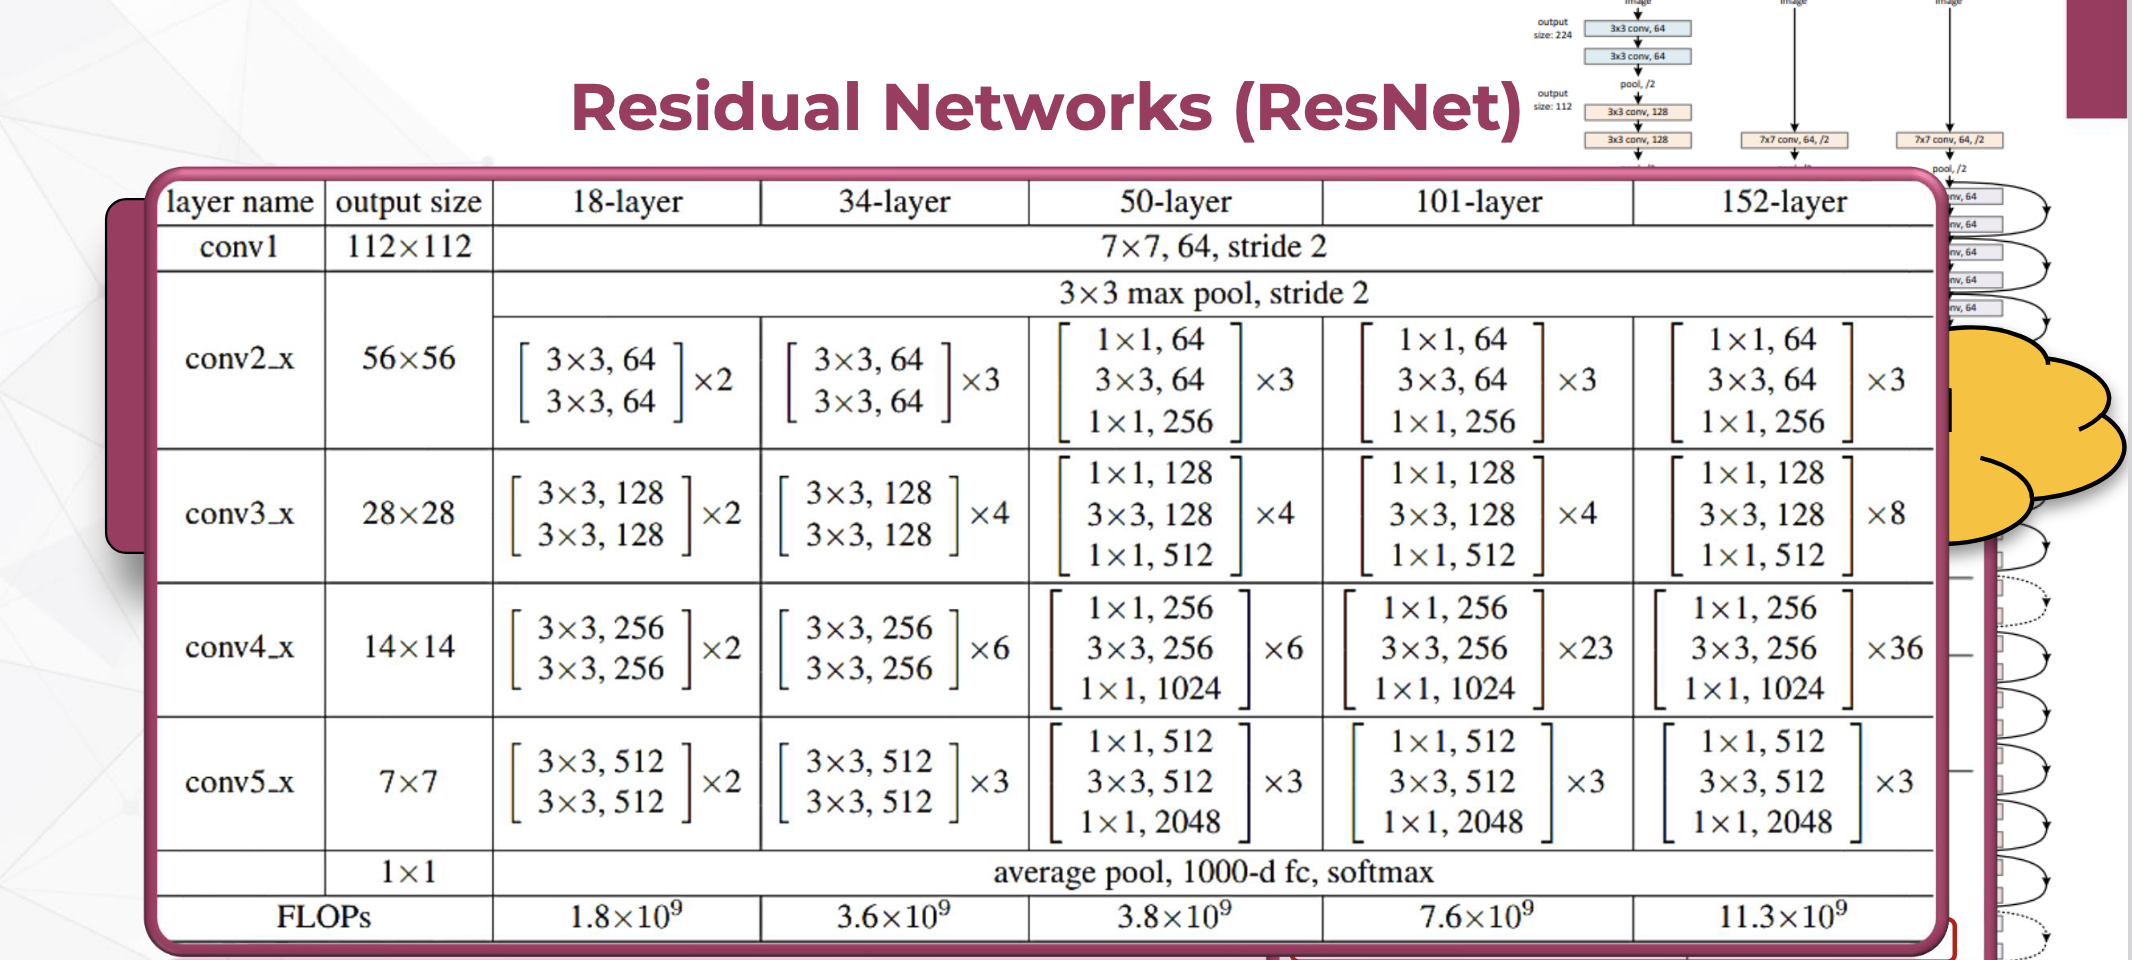

Like GoogLeNet, we add a global average pooling layer, followed by the fully-connected layer output. We define it as a function  so we can reuse later and run it within `tf.distribute.MirroredStrategy`'s scope to utilize various
computational resources, e.g. GPUs. We recreate b1-b5 inside this function's scope.

ALERT: There are 4 convolutional layers in each module (excluding the 1x1
convolutional layer). Together with the first 7x7 convolutional layer and the final fully-connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18. But I need to make ResNet-50.

In [7]:
def net():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(32, kernel_size=7, strides=2, padding='same', input_shape=(96,96,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2- b5 that we created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])
    
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Changed learning rate
    optimizer=tf.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

Check out your model's shape

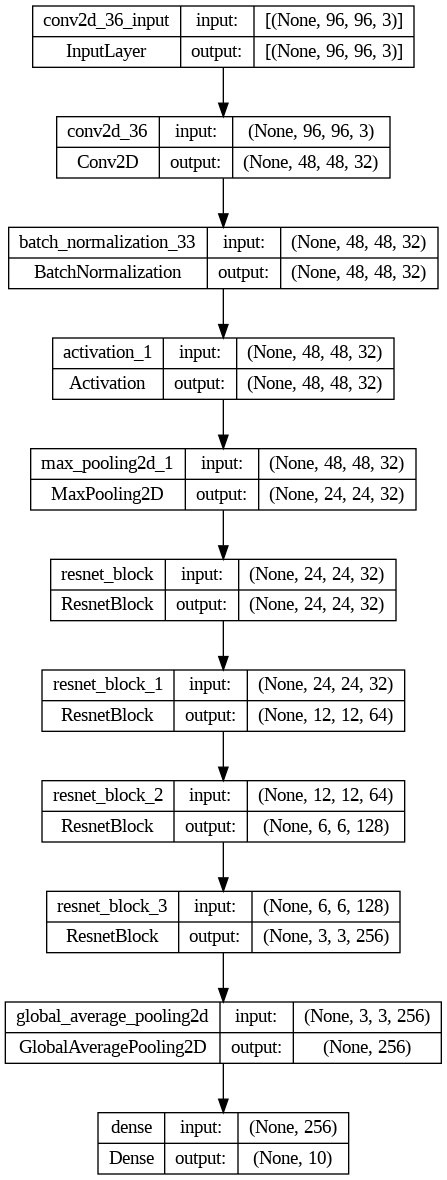

In [8]:
model = net()
tf.keras.utils.plot_model(model, show_shapes=True)

Load, concatenate to redo train/test split to be 70/30.  Normalize and flatten the data.  

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

#then split using train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=(0.3))

#normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

#flatten
y_train, y_test = y_train.flatten(), y_test.flatten()

#create dataframes
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


def process_images(image, label):
    # Resize images from 32x32 to 96x96
    image = tf.image.resize(image, (96,96))
    return image, label




train_dataset = (train_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))
test_dataset = (test_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))



170498071/170498071 [==============================] - 6s 0us/step


Run the model. 50 epochs.

In [10]:
history = model.fit(train_dataset, 
            epochs=50,
            validation_data=test_dataset)

Epoch 1/50
1312/1312 [==============================] - 83s 41ms/step - loss: 1.5565 - accuracy: 0.4346 - val_loss: 1.4653 - val_accuracy: 0.4795
Epoch 2/50
1312/1312 [==============================] - 50s 38ms/step - loss: 1.1565 - accuracy: 0.5865 - val_loss: 1.2815 - val_accuracy: 0.5577
Epoch 3/50
1312/1312 [==============================] - 50s 38ms/step - loss: 0.8884 - accuracy: 0.6895 - val_loss: 1.4516 - val_accuracy: 0.5518
Epoch 4/50
1312/1312 [==============================] - 54s 41ms/step - loss: 0.6393 - accuracy: 0.7797 - val_loss: 1.4110 - val_accuracy: 0.5875
Epoch 5/50
1312/1312 [==============================] - 48s 37ms/step - loss: 0.4538 - accuracy: 0.8401 - val_loss: 1.6181 - val_accuracy: 0.5840
Epoch 6/50
1312/1312 [==============================] - 49s 37ms/step - loss: 0.3333 - accuracy: 0.8816 - val_loss: 2.0482 - val_accuracy: 0.5656
Epoch 7/50
1312/1312 [==============================] - 48s 37ms/step - loss: 0.2602 - accuracy: 0.9077 - val_loss: 2.3946 -

Obtain the training and testing accuracy: 

Visualize the training history


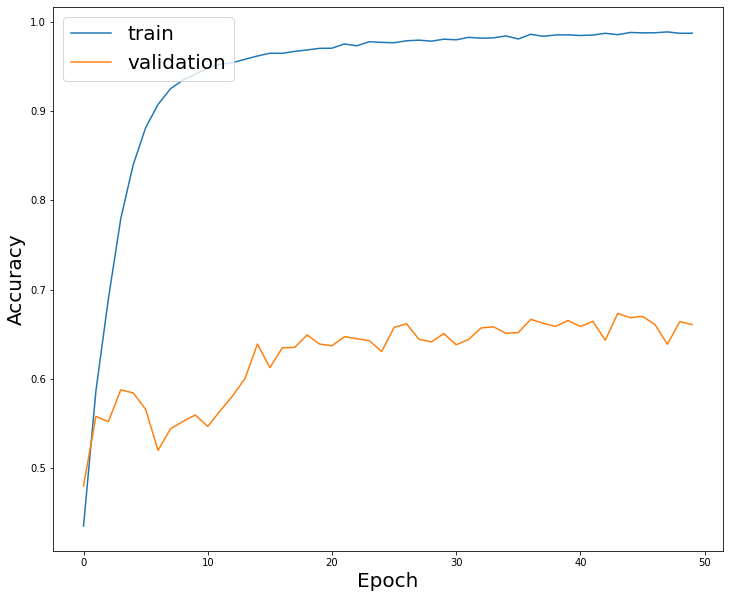

In [11]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

Predict the last ten images in the test set. 

In [20]:
# create subset of last 10 images, labels
lastimages=x_test[-10: ]
lastlabels=y_test[-10: ]
# empty array for results
lastimagesprocessed=[]
# for test image in lastimages subdataset, predict label 
# zip seems like we're just pairing image and label together
for image, label in zip(lastimages, lastlabels):
  images_processed, _= process_images(image,label)
  #we're making a numpy array
  lastimagesprocessed.append(images_processed.numpy()) 

In [21]:
lastimagesprocessed[0].shape

(96, 96, 3)

In [22]:
len(lastimagesprocessed)

10

1/1 [==============================] - 0s 23ms/step


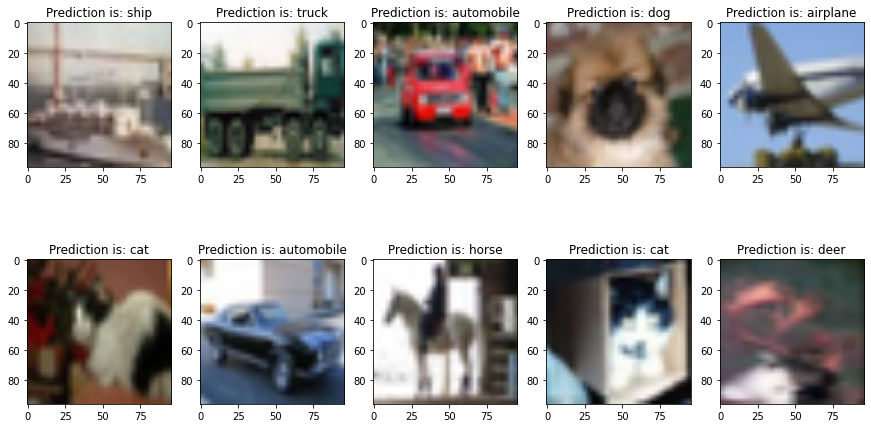

In [24]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()
# take(1)= 1 batch
for i, image in enumerate(lastimagesprocessed):
    #plottable_image = np.reshape(image, (32, 32, 3))
    ax[i].imshow(image)
    ax[i].set_title("Prediction is: {}".format(CLASS_NAMES[model.predict(np.reshape(image, (1,96,96,3))).argmax()]), fontsize=12)

Despite the test accuracy being only 66%, this beast has correctly predicted the last ten images from the test set. Good AI!